# Lung disease classifier based on CapsNet architecture with routing-by-agreement learn algorithm

In [3]:
%load_ext autoreload
%autoreload 2

import sys, os
from pathlib import Path
from pprint import pprint

#-setting up the PYTHONPATH------

# Current directory as Path object
current_dir = Path.cwd()
# get project root folder
project_dir = str(current_dir.parent)
# adding project directory to the PYTHONPATH
if project_dir not in sys.path:
    sys.path.append(project_dir)
    print(f"PYTHONPATH added: {project_dir}")
else:
    print("PYTHONPATH was empty or already in sys.path.")

sys.path.append(project_dir)
pprint(sys.path)

#----setting data paths----
from src import defs

defs.initDataPaths(project_dir)
defs.checkDataPaths()

# --- Standard Library
import os
import random
import subprocess
import time
from pathlib import Path
from timeit import default_timer as timer

# --- Third-Party Libraries
import albumentations as A
import cv2
import mlflow
import numpy as np
import pandas as pd
from keras.saving import register_keras_serializable
from keras.utils import image_dataset_from_directory
from mlflow.tracking import MlflowClient
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import (
    Callback,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau
)
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import (
    CosineDecay,
    ExponentialDecay,
    PiecewiseConstantDecay
)

# --- Local Imports
from src.defs import (
    PROJECT_DIR,
    DatasetType as dt,
    ModelType as mt,
    class_to_disease_map,
    disease_labels
)
from src.models.modelbuilder import (
    ModelBuilder,
    PrimaryCaps,
    DigitCaps,
    Length,
    margin_loss,
    capsnet_custom_objects
)
from src.models.modeltrainer import ModelTrainer
from src.models.modelutilizer import ModelUtilizer
from src.utils.datahelper import DataHelper as dh

# config mlflow
mlruns_dir = os.path.join(PROJECT_DIR, "mlruns_capsnet")
mlruns_uri = Path(mlruns_dir)
mlflow.set_tracking_uri(mlruns_uri)
os.makedirs(mlruns_dir, exist_ok=True)
os.makedirs(os.path.join(mlruns_dir, ".trash"), exist_ok=True)



PYTHONPATH added: c:\Users\User\DataScience\aug24_cds_int_analysis-of-covid-19-chest-x-rays
['C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312',
 'c:\\Users\\User\\DataScience\\env_covid19',
 '',
 'c:\\Users\\User\\DataScience\\env_covid19\\Lib\\site-packages',
 'c:\\Users\\User\\DataScience\\env_covid19\\Lib\\site-packages\\win32',
 'c:\\Users\\User\\DataScience\\env_covid19\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\User\\DataScience\\env_covid19\\Lib\\site-packages\\Pythonwin',
 'c:\\Users\\User\\DataScience\\aug24_cds_int_analysis-of-covid-19-chest-x-rays',
 'c:\\Users\\User\\DataScience\\aug24_cds_int_analysis-of-covid-19-chest-x-rays']
file:///c:/Users/User/DataScience/aug24_cds_int_analysis-of-covid-19-chest-x-rays/mlruns

PROJECT_DIR:  c:\Users\

c:\Users\User\DataScience\env_covid19\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#----balancing the trainig dataset---------------------------------------
# -------------------------------
# >>> Oversampling strategy: fill up each class up to the highest image count across the classes

# create dir to be balanced by oversampling
balanced_for_train_valid_dir = os.path.join(PROJECT_DIR, "data_256x256", "for_disease_classification", "masked", "original", "masked_balanced")
classes = os.listdir(balanced_for_train_valid_dir)
# determine the largest image count across the classes
required_img_count = max([len(os.listdir(os.path.join(balanced_for_train_valid_dir, class_name))) for class_name in classes])


# Gaussian Blur can be included in moderation but should never be dominant in augmentation.
# Maintains low probability and low blur intensity to avoid losing medically important features.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    #A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,    # ±10% horizontal and vertical translation
        scale_limit=0.1,    # no scaling
        rotate_limit=0.05,     #
        p=0.5
    ),
    A.RandomBrightnessContrast(p=0.3),
    A.CLAHE(p=0.3),
    A.GaussianBlur(blur_limit=(3, 3), sigma_limit=(0.1, 0.5), p=0.05)
])


#--oversampling for undersampled classes
for class_name in classes:

    balanced_image_class_dir = os.path.join(balanced_for_train_valid_dir, class_name)
    img_names = os.listdir(balanced_image_class_dir)
    img_count = len(img_names)
    augm_cnt = img_count # start numbering with the next number

    # List images, excluding those with '_augmented_' in their names
    original_img_names = [
        img for img in os.listdir(balanced_image_class_dir)
        if ('_augmented_' not in img) and (img.endswith('.png') or img.endswith('.jpg'))
    ]


    # if the class is still imbalanced
    if img_count < required_img_count:

        print(f"augmentation for {class_name}: ")
        print(f"Original images: {img_count}")
        print(f"Required images: {required_img_count}")

        # Augmentation loop
        while augm_cnt < required_img_count:
            img_name = random.choice(original_img_names)
            img_path = os.path.join(balanced_image_class_dir, img_name)

            # Load the image
            img = cv2.imread(img_path)

            # Apply transformations
            augmented_img = transform(image=img)['image']

            # Update counter
            augm_cnt += 1

            # Save augmented image
            new_img_name = f'{class_name}_augmented_{augm_cnt}.png'
            cv2.imwrite(os.path.join(balanced_image_class_dir, new_img_name), augmented_img)

            # Progress feedback every 1000 images
            if augm_cnt % (1000 + img_count) == 0:
                print(f"Augmented images created: {augm_cnt-img_count}")

        print(f"Total images after augmentation: {augm_cnt}")
    else:
        print(f"Class {class_name} already has {img_count} images. Skipping augmentation.")
        continue



In [12]:
#---training calbacks---
def initCallbacks(model_checkpoint_path, target_val_accuracy):

    class StopAtValAccuracy(Callback):
    # stopps the training (after a completed epoch) once the target_val_accuracy is reached
        def __init__(self, target_val_accuracy):
            super().__init__()
            self.target_val_accuracy = target_val_accuracy

        def on_epoch_end(self, epoch, logs=None):
            val_accuracy = logs.get("val_accuracy")
            if val_accuracy is not None:
                if val_accuracy >= self.target_val_accuracy:
                    print(f"\nReached target validation accuracy of {self.target_val_accuracy*100:.2f}% at epoch {epoch+1}. Stopping training.")
                    self._model.stop_training = True


    class TimingCallback(Callback):
        def __init__(self):
            self.logs = []
        def on_epoch_begin(self, epoch, logs={}):
            self.starttime = timer()
        def on_epoch_end(self, epoch, logs={}):
            self.logs.append(timer()-self.starttime)


    stop_at_specified_val_acc = StopAtValAccuracy(target_val_accuracy=target_val_accuracy)

    time_callback = TimingCallback()

    early_stopping = EarlyStopping(
                        monitor='val_loss', # Keras to watch the validation loss after each epoch
                        mode='min',         # 'min' (for loss) tells EarlyStopping to look for decreases in the monitored value
                        patience=4,         # Wait for x epochs before applying
                        min_delta=0.01,     # If the loss function doesn't change by 1% after patience epochs, either up or down, we stop
                        restore_best_weights=True, # When stopping early, it restores the model weights from the epoch where validation loss was best
                        verbose=1,          # Display the epoch at which training stops
                        )

    reduce_learning_rate = ReduceLROnPlateau(
                                            monitor="val_loss",
                                            patience=3,   # If val_loss stagnates for patience consecutive epochs based on the min_delta value
                                            min_delta=0.01, # If the loss function doesn't change by 1% after patience epochs, either up or down, we stop
                                            min_lr=1e-6, # Prevents LR from being reduced below a floor
                                            factor=0.1,  # Reduce the learning rate by a factor of 0.1
                                            cooldown=3,  # epochs to wait before retrying
                                            verbose=1)


       
    check_point_best_only = ModelCheckpoint(model_checkpoint_path, save_best_only=True) #done by mlflow


    #---->>>adjust
    return [early_stopping, reduce_learning_rate, check_point_best_only]


In [ ]:
#-------------------------------------------
#----capsnet with routing by agreement------
# ---experimenting/training and MLflow logging------------
#-------------------------------------------

# -------------------------------
# ---configure training mode-----
try_kernels_for_1st_con2D_layer = True  # True: experimentation mode with LR sheduler over few epochs to figure out the optimal kernel size range for the 1st conv-layer 
                                        # False: training mode with constant start_LR value
scheduler = "ExponentialDecay"#"PiecewiseConstantDecay" # "CosineDecay"
#----> start_LR is always used
start_LR = 1e-3 

# no schedule
lr_scheduler = start_LR
#-----------------------------------


# if try_kernels_for_1st_con2D_layer==False no heduler is used
if try_kernels_for_1st_con2D_layer:
    if scheduler == "ExponentialDecay":
        """ final_lr = initial_lr * decay_rate ^ (steps / decay_steps)
            1e-6 = 1e-3 * decay_rate^(1911 / 1911)
            → 1e-6 / 1e-3 = decay_rate
            → decay_rate = 1e-3 = 0.001
        """
        lr_sheduler = ExponentialDecay(
            initial_learning_rate=1e-3,
            decay_steps=1911,
            decay_rate=0.001,      # decays from 1e-3 → 1e-6
            staircase=False        # smooth exponential decay
        )
        
    elif scheduler == "CosineDecay":
        """
        final_lr = alpha + (initial_lr - alpha) * 0.5 * (1 + cos(π * step / decay_steps))
        steps_per_epoch = 637
        decay_steps = 3 * steps_per_epoch  # = 1911
        """
        lr_scheduler = CosineDecay(
            initial_learning_rate=1e-3,
            decay_steps=1911,
            alpha=0.001  # Final LR = 0.001 * 1e-3 = 1e-6
        )
        
    elif scheduler == "PiecewiseConstantDecay":
        boundaries = [637, 1274]  # step where LR changes
        values = [1e-3, 1e-4, 1e-5]  # LR values at each stage/epoch start
        lr_scheduler = PiecewiseConstantDecay(boundaries=boundaries, values=values)
    
    

# figure out the best convKernel value for the first conv2D layer lasting for epochs=x only
# use lr_scheduler to define a non-discrete LR decrease
if try_kernels_for_1st_con2D_layer:
    epochs = 3 # check the learning tendency
    validation_split = 0.5 #50 valid 50
    kernels = [3,5,7,9,10,11] # specifiy kernel sizes of interest
    experiment_name = "fit_the_best_kernel_for_1st_conv2D"
    
# ... or go on with regualr long training over selected kernels for the first conv-layer
else:
    epochs = 50
    validation_split = 0.2
    experiment_name = "capsnet_4class_lung_disease_classifier"
    kernels = [9,10,11] #best performed kernels by exploration runs
    
    
# Model params
model_name = None
input_shape = (256, 256, 3) # masked
n_classes = 4 # 4 disease classes
routing_iterations = 3 # commonly used


#---loading dataset---
#train_dataset, val_dataset = loadDataset(validation_split)
balanced_for_train_valid_dir = os.path.join(PROJECT_DIR, "data_256x256", "for_disease_classification", "masked", "original", "masked_balanced")
# params for image_dataset_from_directory(...)
data_loading_params = {
                    "subset"    :           "both",
                    "directory":            balanced_for_train_valid_dir,
                    "batch_size" :          32,
                    "seed":                 42,                       # changed from 1 to 42
                    "label_mode":           "categorical",            # for one-hot encoded labels
                    "color_mode":           "rgb",                    # require 3 channels otherwise needs to be trained from scratch 
                    "image_size":           (256,256),                # img_height, img_width
                    "shuffle":              True,
                    "validation_split":     validation_split,         # 
                    "labels":              "inferred",                # derive from folder structure
}

# get training/validation dataset
val_dataset, train_dataset = dh.load_training_dataset(model_type=mt.CAPSNET, dataset_type=dt.TRAIN, **data_loading_params) 

# set experiment name
mlflow.set_experiment(experiment_name)  # this will create the experiment if it doesn't exist

#----start trainig loop over kernels------
for kernel in kernels:

    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    # Instantiate and compile model
    
    capsnet_config = {
        "first_Conv2DKernel_size": kernel,
        "input_shape": (256, 256, 3),
        "routing_algo": "by_agreement",
    
        "compile_params" : {
            "optimizer": Adam(lr_scheduler),
            "loss": margin_loss,
            "metrics": ["accuracy"]
        },
        "prim_caps": {
            "dim_capsule": 8,
            "n_channels": 32,
            "kernel_size": 9,
            "strides": 2,
            "padding": "same"
        }, 
        "digit_caps":{
            "num_capsule": 4, # 1 capsule per class (e.g. 4 diseases = 4 capsules)
            "dim_capsule": 16, # Each output capsule is a 16D vector → captures pose info
            "routing_iters": 3, # Use 3 iterations of dynamic routing  to refine capsule agreement
        }
    }
    
    model_name = experiment_name+f"_krnl_{kernel}"
    capsnet = ModelBuilder(name = model_name, model_type=mt.CAPSNET, **capsnet_config)
    _, model = capsnet.get_compiled_model()

    # Model Summary
    model.summary()

    def get_nvidia_smi():
        try:
            output = subprocess.check_output(["nvidia-smi"], stderr=subprocess.STDOUT)
            return output.decode("utf-8")
        except (subprocess.CalledProcessError, FileNotFoundError):
            return None  # Return None if command fails or doesn't exist


    # if gpu is used
    is_gpu = len(tf.config.list_physical_devices('GPU'))


    # Enable autologging for GPU only
    if is_gpu:
      mlflow.tensorflow.autolog()
      print("gpu is used")
      print("mlflow.autolog is enabled")


    #----Start MLflow run
    with mlflow.start_run(run_name=model_name) as run:

        print(f"Experiment name/id: {experiment_name}/{experiment_id}")
        print(f"MLflow Run ID/name: {run.info.run_id}/{run.info.run_name}")
        # Optional: log tracking folder path (for local runs)
        # mlflow.log_param("mlflow_run_folder", f"./mlruns/{run.info.experiment_id}/{run.info.run_id}/")

        mlflow.log_param("model_name", model_name)
        
        model_checkpoint_path = os.path.join(mlruns_dir, f"{experiment_id}", f"{run.info.run_id}", "artifacts", "checkpoints", "best_model.keras")
        # init calbacks
        calbcks = initCallbacks(model_checkpoint_path, target_val_accuracy=0.95)

        # --- Training ---
        start_time = time.time()
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            batch_size=32,
            callbacks=[calbcks]
        )
        end_time = time.time()

        # perform logging after successful run only
        training_time = end_time - start_time
        mlflow.log_metric("training_time_seconds", training_time)

        if is_gpu:

          gpu_info = get_nvidia_smi()
          # Save to file
          with open("nvidia_smi.txt", "w") as f:
              f.write(gpu_info)

          # Log to MLflow run folder
          mlflow.log_artifact("nvidia_smi.txt")

        #----Manually log parameters when TPU is used----
        if not is_gpu:

            mlflow.log_param("hardware", "TPU")
            mlflow.log_param("epochs", len(history.history["loss"]))

            # Manually log metrics
            for key, values in history.history.items():
                for epoch, value in enumerate(values):
                    mlflow.log_metric(key, value, step=epoch)
                    print(f"Logged metric: {key} = {value} at epoch {epoch}")



In [ ]:
# if colab crashes or session expires in the midle of traning use this function to continue
# the histories from resulted mlruns needs to be merged to get an complete overview over the traning     
def resume_training_for_runID_starting_at_next_epoch_with_LR(experiment_id, run_id, mlruns_dir, alt_model_from_check_point=False, dflt_LR=None, **data_loading_params):
    #---resume the training after session expiration starting with the next epoch and last used LR or use dflt_LR if specified--------
    
    # Setup MLflow tracking
    mlruns_uri = Path(mlruns_dir)
    mlflow.set_tracking_uri(mlruns_uri)
    mlflow.tensorflow.autolog()
    
    # client to acces mlruns
    client = MlflowClient()

    # Get epoch and LR info
    metric_history = client.get_metric_history(run_id, "val_loss")
    lr_history = client.get_metric_history(run_id, "learning_rate")

    # Calculate next epoch number and last LR
    next_epoch = max(m.step for m in metric_history) + 1 if metric_history else 0
    last_lr_used = sorted(lr_history, key=lambda x: x.step)[-1].value if lr_history else dflt_LR

    
    model_path = None
    # Load the model
    if alt_model_from_check_point:# from checkpoint
        model_path = os.path.join(mlruns_dir, f"{experiment_id}", f"{run_id}", "artifacts", "checkpoints", "best_model.keras")
   
    else: # from the /model/data folder
        model_path = os.path.join(mlruns_dir, f"{experiment_id}", f"{run_id}", "artifacts", "model", "data", "model.keras")

    # custom objects which ar not a part of keras library
    model = load_model(model_path, custom_objects=capsnet_custom_objects)

    # load training/validation dataset
    val_dataset, train_dataset = dh.load_training_dataset(model_type=mt.CAPSNET, dataset_type=dt.TRAIN, **data_loading_params) 


    #----Start MLflow run
    with mlflow.start_run(run_id=run_id) as run:

        # Recompile with optimizer and learning rate as seen in last training
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=last_lr_used),
                      loss=margin_loss,
                      metrics=['accuracy'])

        # Resume training
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            initial_epoch=next_epoch,  # Resume at epoch xxx
            epochs=50,
            callbacks=calbcks
        )


#----usage example  
balanced_for_train_valid_dir = os.path.join(PROJECT_DIR, "data_256x256", "for_disease_classification", "masked", "original", "masked_balanced")
# params for image_dataset_from_directory(...)
data_loading_params = {
                    "subset"    :           "both",
                    "directory":            balanced_for_train_valid_dir,
                    "batch_size" :          32,
                    "seed":                 42,                       # changed from 1 to 42
                    "label_mode":           "categorical",            # for one-hot encoded labels
                    "color_mode":           "rgb",                    # require 3 channels otherwise needs to be trained from scratch 
                    "image_size":           (256,256),                # img_height, img_width
                    "shuffle":              True,
                    "validation_split":     validation_split,         # 
                    "labels":              "inferred",                # derive from folder structure
}

resume_training_for_runID_starting_at_next_epoch_with_LR(experiment_id="723732156685390614", run_id="3a05b836fa94479a87e9afa4b1469669", mlruns_dir=mlruns_dir, alt_model_from_check_point=True, dflt_LR=1e-5, **data_loading_params)


In [9]:
# -------get training history from mlruns and save to csv-----
mlruns_capsnet_uri = Path(os.path.join(PROJECT_DIR, "mlruns_capsnet")).as_uri()
dh.set_mlflow_tracking(mlruns_capsnet_uri)
metrics_all_runs_output_csv = os.path.join(PROJECT_DIR, "csv_files", "disease_prediction", "capsnet_metrics_all_runs.csv")
# ----!!!don't run again!!! returns empty df because no data in mlruns
# df_metrics = dh.get_per_epoch_metrics_from_mlruns(experiment_ids=["923962217935764323"], output_csv_path=metrics_all_runs_output_csv)
# df_metrics.head()

In [14]:
#show training history by run_id from csv 

metric_csv_file_path = os.path.join(PROJECT_DIR, "csv_files", "disease_prediction", "capsnet_metrics_all_runs.csv")
df = pd.read_csv(metric_csv_file_path)
df.to_csv(metric_csv_file_path, index=False)
dh.show_training_history_from_csv(metric_csv_file_path)


"""
* based on the graphics below only a set of models will be selected for test run on unkbnown dataset 
* the best candidates are models with run_ids: 268..cd55, dff..798a, fe8..704a 
"""


'\n* based on the graphics below only a set of models will be selected for test run on unkbnown dataset \n* the best candidates are models with run_ids: 268..cd55, dff..798a, fe8..704a \n'

In [14]:
# ----predict on dataset unknown to the model------------

mlruns_capsnet_uri = Path(os.path.join(PROJECT_DIR, "mlruns_capsnet")).as_uri()
mlruns_capsnet_dir = os.path.join(PROJECT_DIR, "mlruns_capsnet")
dh.set_mlflow_tracking(mlruns_capsnet_uri)
experiment_id="923962217935764323"

#only for active runs
run_ids = dh.get_run_ids(experiment_id) #only for active runs

dataset_dir = os.path.join(PROJECT_DIR, "data_256x256", "for_disease_classification", "masked", "unknown_to_the_model", "labeled_for_test")
#dataset_dir = os.path.join(PROJECT_DIR, "data_256x256", "for_disease_classification", "masked", "unknown_to_the_model", "short_test_set")

list_df_pred = []
df_predicted = None
for run_id in run_ids:

    model_path = os.path.join(mlruns_capsnet_dir, f"{experiment_id}", f"{run_id}", "artifacts", "model", "data", "model.keras")
    # utilizer object with loaded model from path
    u = ModelUtilizer(model_type=mt.CAPSNET, input_shape=(256,256,3), alt_model_path=model_path, custom_objects=capsnet_custom_objects)
    # prediction csv path
    csv_path = os.path.join(PROJECT_DIR, "csv_files", "disease_prediction", f"test_on_unknown_dataset_{u.model_name}.csv")
     
    df_predicted, time_spent = u.predict_on_dataset(dataset_type=dt.TEST, 
                                                    dataset_dir=dataset_dir,
                                                    class_to_label_map=class_to_disease_map, 
                                                    csv_output_path=csv_path)
    
    df_predicted.to_csv(csv_path, index=False)
    list_df_pred.append(df_predicted)
    u.show_classification_report(df_predicted, title=u.model_name, normalize_cm=None, labels=disease_labels)


    



In [ ]:
#------------determine the best model from test prediction results

# load all csv data to one df 
df = None
csv_dir = os.path.join(PROJECT_DIR, "csv_files", "disease_prediction")
out_path = os.path.join(PROJECT_DIR, "csv_files", "disease_prediction", f"test_on_unknown_dataset_all_capsnet_models.csv")

csv_files = [
    f for f in os.listdir(csv_dir)
    if f.endswith(".csv") and "_krnl" in f
]

# List to collect individual DataFrames
dataframes = []

# Load each CSV, tag with model name, and append to list
for filename in csv_files:
    file_path = os.path.join(csv_dir, filename)
    df = pd.read_csv(file_path)
    # Add a 'model' column with the filename (without .csv)
    model_name = os.path.splitext(filename)[0]
    df['model'] = model_name
    

    dataframes.append(df)

# Merge all DataFrames into one ansd save
df_merged = pd.concat(dataframes, ignore_index=True)
df_merged.to_csv(out_path, index=False)

# Filter rows where prediction was correct
correct_preds = df_merged[df_merged['true_label'] == df_merged['predicted_label']]

# Group by model and true_label
correct_counts_per_label = (
    correct_preds
    .groupby(['model', 'true_label'])
    .size()
    .reset_index(name='correct_count')
    .sort_values(by=['model', 'true_label'])
)

# Display result
display(correct_counts_per_label.head(50))


#determine 
correct_preds_per_model = (
    correct_preds
    .groupby(['model'])
    .size()
    .reset_index(name='true_positives')
    .sort_values(by=['true_positives'], ascending=False)
)
display(correct_preds_per_model)




Classification report for knl10_keras: best for COVID & best over all
                 precision    recall  f1-score   support

          COVID       0.90      0.69      0.78      1074
   Lung_Opacity       0.00      0.00      0.00         0
         Normal       0.77      0.91      0.83      1525
Viral Pneumonia       1.00      0.83      0.91      1525

       accuracy                           0.82      4124
      macro avg       0.67      0.61      0.63      4124
   weighted avg       0.89      0.82      0.85      4124



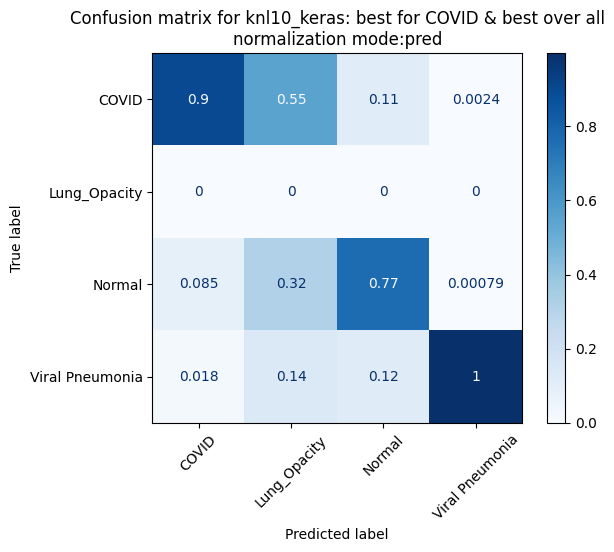

In [13]:

"""considering the result before:

	test_on_unknown_dataset_capsnet_lung_disease_classifier_krnl10.keras : is best over all accuracy & best accuracy for COVID class
        
"""
knl10_keras_path = os.path.join(PROJECT_DIR, "csv_files", "disease_prediction", "test_on_unknown_dataset_capsnet_lung_disease_classifier_krnl10.keras.csv")
for p, t in [(knl10_keras_path,"knl10_keras: best for COVID & best over all"),]:
    df = pd.read_csv(p)
    ModelUtilizer.show_classification_report(df, title=t,  normalize_cm="pred", labels=disease_labels)